# Классификация с использованием PyTorch

## Описание проекта
В данном проекте реализуется задача классификации на основе синтетически сгенерированных данных с помощью make_blobs. Мы создаем три класса и обучаем простую нейронную сеть для их разделения.

## Основные шаги:
1. Генерация данных с помощью make_blobs.
2. Визуализация данных.
3. Реализация модели с использованием PyTorch.
4. Обучение и оценка модели.

## Метрики:
- Используемая метрика: точность (`accuracy`).
- Итоговая точность модели: около 99% на тестовых данных.

## Зачем это нужно?
Проект создан для демонстрации основ использования PyTorch для задач классификации. Это отличный пример для новичков, чтобы понять, как работает нейронная сеть.

In [13]:
import matplotlib.pyplot as plt
import torch

In [1]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=10000, n_features=3, random_state=123)

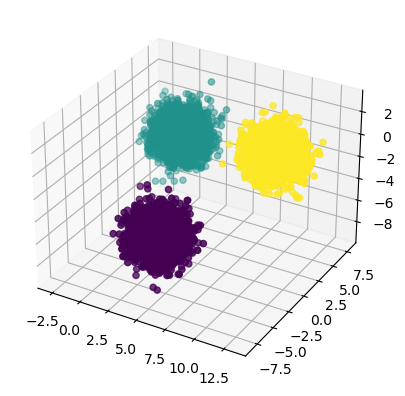

In [9]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X[:, 0], X[:, 1], X[:, 2], c=y)
plt.show()

In [11]:
from torch.utils.data import Dataset

class BlobDataset(Dataset):
    def __init__(self, features, targets):
        super().__init__()
        self.features = torch.from_numpy(features).type(torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.targets[index]

In [14]:
dataset = BlobDataset(X, y)
print(dataset)

In [16]:
print(len(dataset))

10000


In [17]:
print(dataset[0])

(tensor([ 5.1478, -3.7830, -4.8408]), tensor(0))


In [18]:
from torch.utils.data import random_split
train, test = random_split(dataset=dataset, lengths=[0.8, 0.2])

In [20]:
from torch.utils.data import DataLoader
batch_size = 128
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)

In [21]:
data_iter = iter(train_loader)
first = next(data_iter)
print(first[0])

tensor([[10.3013,  2.5419, -2.0223],
        [ 8.3435,  3.8963, -1.1562],
        [ 1.3925,  4.1206, -2.9298],
        [ 2.7231, -4.2986, -5.3475],
        [ 4.8728, -4.1893, -6.2744],
        [ 0.8592,  3.7881,  0.0178],
        [11.3863,  5.0103, -1.0154],
        [10.0270,  2.8881, -0.9158],
        [ 9.7364,  3.5170, -0.5734],
        [ 2.8003, -4.7738, -4.4143],
        [ 5.3141, -4.2541, -6.2940],
        [ 2.5056,  2.1538, -0.4767],
        [ 9.9183,  4.7979,  1.5559],
        [ 3.8719, -3.9144, -5.4978],
        [ 9.4732,  4.1147, -0.1164],
        [11.0322,  3.6734, -0.0262],
        [-1.3956,  3.6832, -1.6559],
        [10.5829,  3.9367, -0.3698],
        [ 0.5832,  3.1903, -0.8043],
        [ 3.5122, -3.0686, -5.8083],
        [ 8.3902,  4.6965, -1.5739],
        [ 0.9255,  5.1765, -0.3925],
        [ 1.5508,  5.4478, -2.9405],
        [ 7.7765,  3.3030, -0.1736],
        [ 3.9896, -4.6507, -4.6836],
        [10.7947,  1.9996, -2.9412],
        [-0.0563,  4.1351, -1.5466],
 

In [22]:
import torch.nn as nn

class BlobClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

In [23]:
input_size = len(X[0])
hidden_size = 128
output_size = len(set(y))

model = BlobClassifier(input_size, hidden_size, output_size)
print(model)

BlobClassifier(
  (fc1): Linear(in_features=3, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
  (relu): ReLU()
)


In [25]:
import torch.optim as optim

learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [26]:
criterion = nn.CrossEntropyLoss()

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [32]:
def train(model, train_loader, criterion, optimizer, print_every, epoch, num_epochs):
    model.train()
    train_loss = 0.0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        train_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        if batch_idx % print_every == 0:
            print(f'Epoch [{epoch + 1:03}/{num_epochs:03}] Batch [{batch_idx+1:03}/{len(train_loader):03}], Train Loss: {train_loss/print_every:.4f}')

            train_loss = 0.0

In [33]:
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    avg_loss = val_loss / len(val_loader)
    accuracy = correct / total

    print(f'Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')

In [35]:
num_epochs = 50
model.to(device)
for epoch in range(num_epochs):
    train(model, train_loader, criterion, optimizer, 500, epoch, num_epochs)
    validate(model, test_loader, criterion, device)
    print('\n----------------------\n')

Epoch [001/050] Batch [001/063], Train Loss: 0.0001
Validation Loss: 0.0298, Accuracy: 99.85%

----------------------

Epoch [002/050] Batch [001/063], Train Loss: 0.0000
Validation Loss: 0.0176, Accuracy: 99.85%

----------------------

Epoch [003/050] Batch [001/063], Train Loss: 0.0000
Validation Loss: 0.0115, Accuracy: 99.90%

----------------------

Epoch [004/050] Batch [001/063], Train Loss: 0.0000
Validation Loss: 0.0080, Accuracy: 99.95%

----------------------

Epoch [005/050] Batch [001/063], Train Loss: 0.0000
Validation Loss: 0.0056, Accuracy: 99.95%

----------------------

Epoch [006/050] Batch [001/063], Train Loss: 0.0000
Validation Loss: 0.0043, Accuracy: 99.95%

----------------------

Epoch [007/050] Batch [001/063], Train Loss: 0.0000
Validation Loss: 0.0036, Accuracy: 99.95%

----------------------

Epoch [008/050] Batch [001/063], Train Loss: 0.0000
Validation Loss: 0.0028, Accuracy: 99.95%

----------------------

Epoch [009/050] Batch [001/063], Train Loss: 0.0

In [36]:
data = torch.tensor([0.0, 0.0, -8.0], device=device)
with torch.inference_mode():
    preds = model(data)
    preds = torch.functional.F.softmax(preds, dim=0)
    max_idx = torch.argmax(preds)
    print(max_idx.item())

1
